# Integration with human and mouse lung cell atlas
Will use [SATURN](https://github.com/snap-stanford/saturn) that uses a "macrogene" concept that incorporates protein sequence similarities to better bridge cross-species relationships.  

Need the `saturn` conda environment, generated by running `conda env create -f saturn-env.yml`  

Also downloaded the protein embedding files from: http://snap.stanford.edu/saturn/data/protein_embeddings.tar.gz  

Prefiltered data files for the lung cell atlases will be downloaded programmatically.

As a first test, try to integrate the Tata basal cell data.

#### Fetal lung atlas  
https://fetal-lung.cellgeni.sanger.ac.uk/scRNA.html  
scRNA-seq data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE264407   
hPSC-derived lung (~fetal) organoids: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE266789  


### Workflow

#### SATURN takes as an input:

* multiple scRNA-seq count datasets from different species (AnnDatas), with cell type annotations.
* protein embeddings generated by large language models (TorchDicts)

#### SATURN is composed of three modules:
* Macrogene initialization with Kmeans (`scipy`)
* Pretraining conditional autoencoder (`scVI ZINB loss`)
* Fine tuning cell clusters with weakly supervised metric learning


### Load required Python libraries

For loading data

In [1]:
import scanpy as sc
import os
from pathlib import Path
import pandas as pd
import numpy as np
from anndata import AnnData
from anndata.io import read_csv
import seaborn as sns
from matplotlib import pyplot as plt
from glob import glob

import warnings
warnings.filterwarnings('ignore')

### Define path to data

In [2]:
DATADIR = Path('/Volumes/Hackathon1/DukeSeq/LungAtlas')
DATADIR2 = Path(DATADIR,"../Basal_organoids_scRNAseq")
PROCESS_BASAL = False # Set to True to extract primary basal cell data from allograft + Tata data h5ad file

if not DATADIR.exists() or not DATADIR2.exists():
    raise FileNotFoundError(f"Data directory {DATADIR} or {DATADIR2} not found.")

### If data don't exist, download
For SATURN, must use gene names rather than ENSEMBL gene ids; need to change `var_names` as appropriate and save as new adata object

In [3]:
orig_hla_path = Path(DATADIR, "b351804c-293e-4aeb-9c4c-043db67f4540.h5ad")
hla_url = 'https://datasets.cellxgene.cziscience.com/b351804c-293e-4aeb-9c4c-043db67f4540.h5ad'
mod_hla_path = Path(DATADIR, "human_lung_atlas.h5ad")

if not orig_hla_path.exists():
    os.system(f'wget -O {hla_path} {hla_url}')

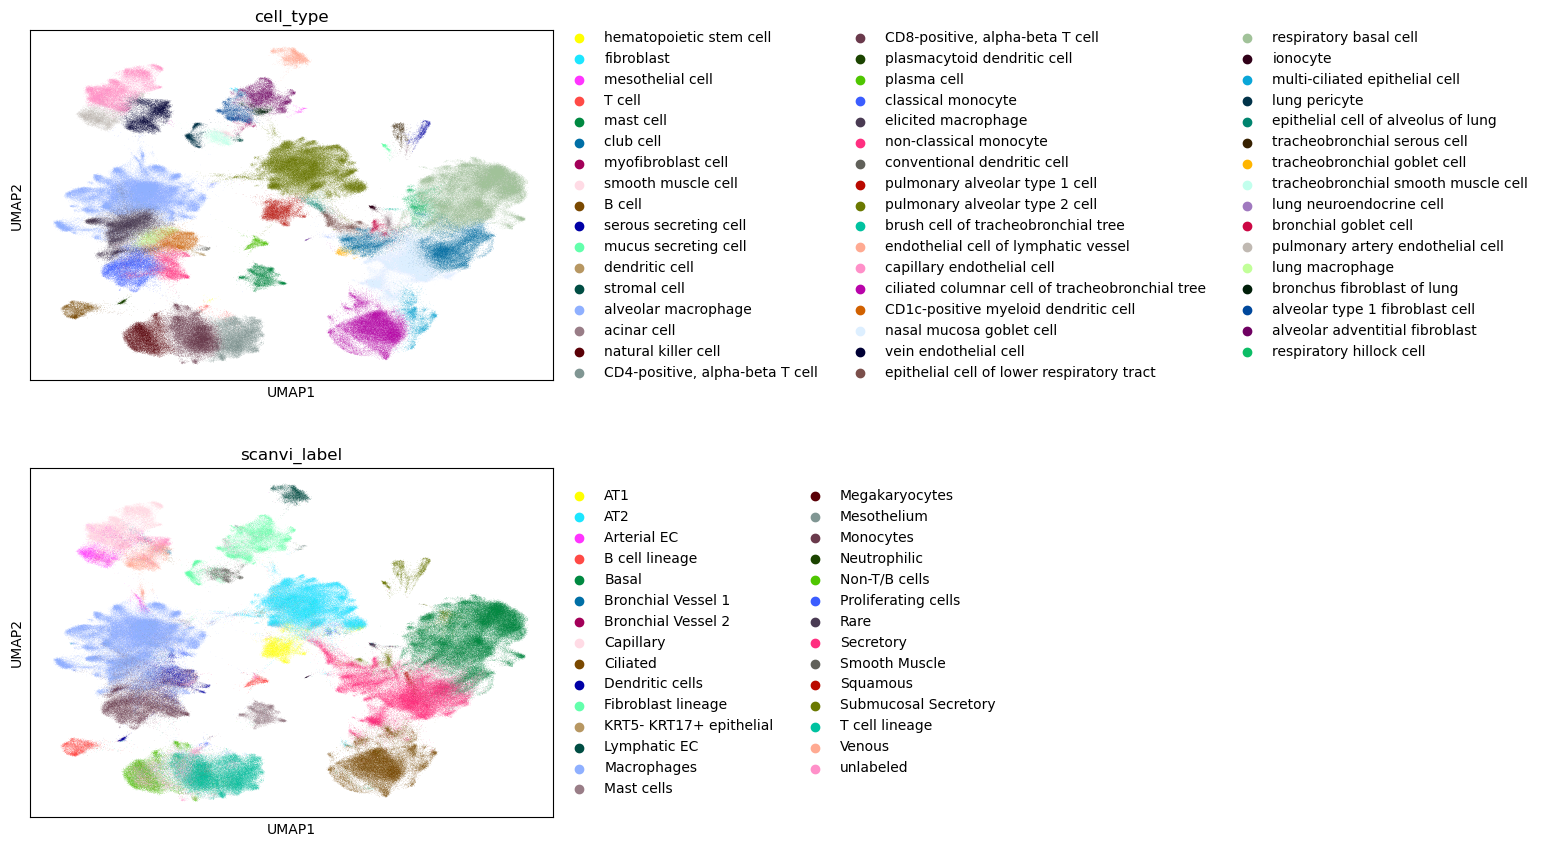

Saving modified h5ad file to /Volumes/Hackathon1/DukeSeq/LungAtlas/human_lung_atlas.h5ad


In [4]:
if not mod_hla_path.exists():
    hla = sc.read_h5ad(orig_hla_path)
    if 'hla_ensembl_gene_id' not in globals():
        hla_ensembl_gene_id = hla.var_names
        hla.var['ensembl_gene_id'] = hla_ensembl_gene_id
        hla.var_names = hla.var['feature_name']
    sc.pl.umap(hla, color=['cell_type','scanvi_label',], ncols=1)
    print(f"Saving modified h5ad file to {mod_hla_path}")
    hla.write_h5ad(mod_hla_path)

In [5]:
tata_path = Path(DATADIR, "Tata_basal_cells_20250214.h5ad")
basal_path = Path(DATADIR2, "010325_adata2_basal_cells_orgs_allos.h5ad")

if tata_path.exists():
    print(f"Tata mouse basal cell data found. Loading file {tata_path}")
    primary_basal = sc.read_h5ad(tata_path)
else:
    print(f"Tata data file {tata_path} not found. Will process from other data file")
    if not basal_path.exists():
        raise FileNotFoundError(f"Data file {basal_path} not found.")
    else:
        PROCESS_BASAL = True
        basal = sc.read_h5ad(basal_path)

Tata mouse basal cell data found. Loading file /Volumes/Hackathon1/DukeSeq/LungAtlas/Tata_basal_cells_20250214.h5ad


In [6]:
if PROCESS_BASAL:
    print("Processing basal cell data")
    basal.obs = basal.obs[['Model','cluster','UnID']].copy()
    basal.var = basal.var[['mito','total_counts']].copy()

    keep_uns = ['UnID_colors','leiden','neighbors','umap']
    uns_list = [basal.uns[x] for x in basal.uns.keys() if x in keep_uns]
    basal.uns = dict(zip(keep_uns, uns_list))

    del basal.obsm['X_scVI_1.1']
    del basal.obsm['X_scVI_1.2']
    del basal.obsm['_scvi_extra_continuous_covs']
    del basal.varm

    prim_mask = basal.obs['UnID'].str.contains('Primary')
    basal = basal[prim_mask].copy()

    sc.pl.umap(basal, color=['cluster','Model'], frameon=False, ncols=2)

    basal.obs['cell_type'] = ['Basal'] * basal.shape[0]
    basal.write_h5ad(tata_path)


### Following example notebook
https://github.com/snap-stanford/SATURN/blob/main/Vignettes/frog_zebrafish_embryogenesis/Train%20SATURN.ipynb

In [7]:
embed_path_base = Path('/Volumes/Hackathon1/DukeSeq/SATURN/protein_embeddings_export/protXL')
df = pd.DataFrame(columns=["path", "species", "embedding_path"])
df["species"] = ["human", "mouse"]
df["path"] = [mod_hla_path, tata_path]
df["embedding_path"] = [Path(embed_path_base,"human_embedding.torch"), Path(embed_path_base,"mouse_embedding.torch")]
df

,path,species,embedding_path
0,/Volumes/Hackathon1/DukeSeq/LungAtlas/human_lu...,human,/Volumes/Hackathon1/DukeSeq/SATURN/protein_emb...
1,/Volumes/Hackathon1/DukeSeq/LungAtlas/Tata_bas...,mouse,/Volumes/Hackathon1/DukeSeq/SATURN/protein_emb...


In [8]:
if not Path(DATADIR, "SATURN_primary_basal_HLA_20250214.csv").exists():
    df.to_csv(Path(DATADIR, "SATURN_primary_basal_HLA_20250214.csv"), index=False)

In [9]:
run_info_path = Path(DATADIR, "SATURN_primary_basal_HLA_20250214.csv")
%env SATURN_RUN_INFO=$run_info_path

!python3 ../../train-saturn.py --in_data=$SATURN_RUN_INFO \
                              --in_label_col=cell_type --ref_label_col=cell_type \
                              --num_macrogenes=2000     --hv_genes=8000          \
                            #   --centroids_init_path=saturn_results/hm_centroids.pkl \
                              --work_dir=. \
                              --device_num=7 \

env: SATURN_RUN_INFO=/Volumes/Hackathon1/DukeSeq/LungAtlas/SATURN_primary_basal_HLA_20250214.csv
Using MPS Device (detected Apple silicon)
Using Device 0
Set seed to 0
After loading the anndata human View of AnnData object with n_obs × n_vars = 584944 × 18072
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'f

In [10]:
!python3 ../../train-saturn.py --help

usage: train-saturn.py [-h] [--in_data IN_DATA] [--device DEVICE]
                       [--device_num DEVICE_NUM] [--time_stamp TIME_STAMP]
                       [--org ORG] [--log_dir LOG_DIR] [--work_dir WORK_DIR]
                       [--seed SEED] [--in_label_col IN_LABEL_COL]
                       [--ref_label_col REF_LABEL_COL]
                       [--tissue_subset TISSUE_SUBSET]
                       [--tissue_column TISSUE_COLUMN] [--hv_genes HV_GENES]
                       [--hv_span HV_SPAN] [--num_macrogenes NUM_MACROGENES]
                       [--centroids_init_path CENTROIDS_INIT_PATH]
                       [--embedding_model {ESM1b,MSA1b,protXL,ESM1b_protref,ESM2}]
                       [--centroid_score_func {default,one_hot,smoothed}]
                       [--vae [VAE]] [--hidden_dim HIDDEN_DIM]
                       [--model_dim MODEL_DIM]
                       [--binarize_expression [BINARIZE_EXPRESSION]]
                       [--scale_expression [SCAL

### Troubleshooting SATURN code

In [11]:
import torch
import torch.nn as nn

# Load the saved state dictionary
# hum_embed = torch.load(Path(embed_path_base,'human_embedding.torch'))
# mouse_embed = torch.load(Path(embed_path_base,'mouse_embedding.torch'))


### Test for Apple silicon (MPS)

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    print("Testing MPS...")
    device = torch.device('mps')
    x = torch.rand(3, 3)
    x_mps = x.to('mps')
    print("Tensor on MPS:", x_mps)
    y = x_mps * 2
    print("Tensor operation result on MPS:", y)
else:
    device = torch.device('cpu')

print(f"Selected device: {device}")

Testing MPS...
Tensor on MPS: tensor([[0.0958, 0.0319, 0.3773],
        [0.8200, 0.4376, 0.5111],
        [0.7196, 0.1844, 0.7298]], device='mps:0')
Tensor operation result on MPS: tensor([[0.1916, 0.0638, 0.7546],
        [1.6399, 0.8753, 1.0222],
        [1.4392, 0.3688, 1.4596]], device='mps:0')
Selected device: mps


In [13]:
import sys
sys.path.append('../../data')
from gene_embeddings import load_gene_embeddings_adata

def get_gene_embedding_path(species: list = ['human','mouse'], model: str = 'protXL', base_embedding_path: str = '') -> dict[str, Path]:
    paths = []
    for species_item in species:
        paths.append(Path(base_embedding_path,model,f'{species_item}_embedding.torch'))
    return dict(zip(species, paths))

embed_path = '/Volumes/Hackathon1/DukeSeq/SATURN/protein_embeddings_export'
pte = get_gene_embedding_path(['human','mouse'], base_embedding_path=embed_path)
load_gene_embeddings_adata(hla, ['human'], 'protXL', pte['human'])

(View of AnnData object with n_obs × n_vars = 584944 × 18072
     obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_l